In [3]:
import warnings

import json
import time

import entwiner
import geopandas as gpd
import plotnine as p
from shapely.geometry import shape
from shapely.ops import transform

# Suppress warnings
warnings.filterwarnings('ignore')

In [10]:
!cp ../artifacts/unweaver/graph.gpkg ../artifacts/unweaver/graph.facilities.gpkg

In [11]:
G = entwiner.DiGraphDB(path="../artifacts/unweaver/graph.facilities.gpkg")
points = gpd.read_file("../artifacts/seattle_nodes.gpkg")
polygons = gpd.read_file("../artifacts/seattle_ways.gpkg")

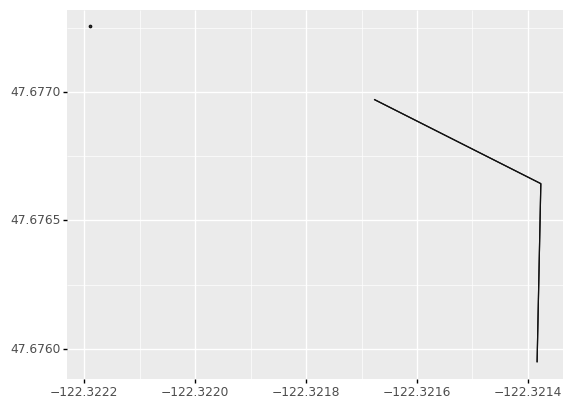

<ggplot: (8744917100939)>

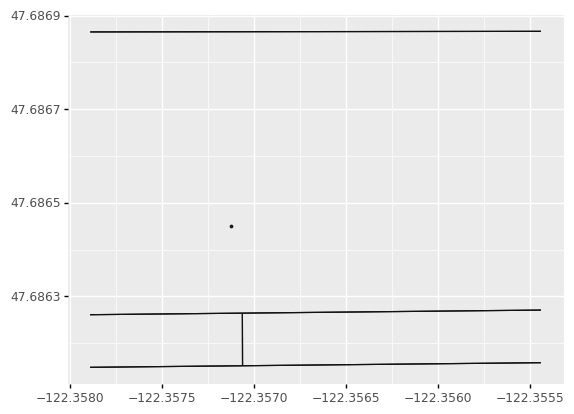

<ggplot: (8744917070580)>

In [12]:
for i in range(2, 4):
    point = points.iloc[i]["geometry"]
    nearby = list(G.network.edges.dwithin(point.x, point.y, 50))
    
    nearby_df = gpd.GeoDataFrame([{
        **d,
        "geometry": shape(d["geom"])
    } for u, v, d in nearby])
        
    if nearby_df.shape[0]:
        if "geom" in nearby_df.columns:
            nearby_df.drop(columns="geom", inplace=True)
            
        point_df = gpd.GeoDataFrame([{
            "geometry": point
        }])

        display(
        p.ggplot(nearby_df)
        + p.geom_map()
        + p.geom_map(data=point_df)
        )

In [13]:
start = time.time()

facility_edge_pairs = []

def label_edges(point_row, distance=50):
    point_geom = point_row["geometry"]
    facility = point_row["facility"]
    nearby_edges = G.network.edges.dwithin(point_geom.x, point_geom.y, 50)
    for u, v, edge in nearby_edges:
        facility_edge_pairs.append({
            "facility_osm_id": point_row["osm_id"],
            "edge_fid": edge["fid"],
            "facility": facility,
        })
#         if facility in d and d[facility] is not None:
#             G[u][v][facility] += 1
#         else:
#             G[u][v][facility] = 1

points.apply(label_edges, axis=1);

end = time.time()

print(time.time() - start)

start = time.time()

# facility_edge_pairs = []

def label_edges_ways(way_row, distance=50):
    way_geom = way_row["geometry"]
    facility = way_row["facility"]
    
    left, bottom, right, top = way_geom.bounds
    
    left, bottom = G.network.edges.transformer.transform(left, bottom)
    right, top = G.network.edges.transformer.transform(right, top)
    
    left -= distance
    bottom -= distance
    right += distance
    top += distance
        
    left, bottom = G.network.edges.transformer.transform(left, bottom, direction="INVERSE")
    right, top = G.network.edges.transformer.transform(right, top, direction="INVERSE")
        
    nearby_edges = G.network.edges.intersects(left, bottom, right, top)
    
    for edge in nearby_edges:
        edge_geom = shape(edge["geom"])
        edge_geom = transform(G.network.edges.transformer.transform, edge_geom)
        polygon_geom = transform(G.network.edges.transformer.transform, way_geom)
        if polygon_geom.distance(edge_geom) < distance:
            facility_edge_pairs.append({
                "facility_osm_id": way_row["osm_id"],
                "edge_fid": edge["fid"],
                "facility": facility,
            })
#         if facility in d and d[facility] is not None:
#             G[u][v][facility] += 1
#             print(1)
#         else:
#             G[u][v][facility] = 1

polygons.apply(label_edges_ways, axis=1);

print(time.time() - start)

2.681086301803589
15.644183158874512


In [14]:
facility_edge_pairs[0]

{'facility_osm_id': 356540545, 'edge_fid': 83717, 'facility': 'school'}

In [15]:
if "facility_edges" in G.network.gpkg.feature_tables:
    G.network.gpkg.feature_tables["facility_edges"].drop_tables()
    # TODO put drop_feature_table in GeoPackage class?
    G.network.gpkg.feature_tables.pop("facility_edges")
    
facility_edges_table = G.network.gpkg.add_feature_table("facility_edges", "LineString")

facility_edges_table.write_features(facility_edge_pairs)

In [16]:
len(facility_edges_table)

50468